In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from symspellpy.symspellpy import SymSpell, Verbosity
from sklearn.model_selection import train_test_split

import collections
import torch
import torch.nn as nn
from torch import optim
import random
import time

[nltk_data] Downloading package wordnet to /home/ashwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('data/labeled_prelim_lda.csv')
df = df.dropna()
df.pop('Id')
df = df.astype({'Relevancy':np.int32, 'Urgency':np.int32})
df.head()

,Text,Relevancy,Urgency,top0,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14
0,millions afghanistan even zero attack isis sym...,0,0,0.0,0.326608,0.000000,0.098502,0.089703,0.000000,0.000000,0.000000,0.158985,0.000000,0.088616,0.000000,0.0,0.0,0.191432
1,last post brother make social media phone go v...,2,1,0.0,0.000000,0.267500,0.000000,0.000000,0.000000,0.000000,0.000000,0.145833,0.106667,0.000000,0.106667,0.0,0.0,0.306667
2,listen local officials epa help harvey respons...,0,0,0.0,0.000000,0.314598,0.132971,0.000000,0.258455,0.202309,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,damn proud tirelessly help fellow texans affec...,3,0,0.0,0.000000,0.088902,0.088699,0.000000,0.110020,0.000000,0.154831,0.000000,0.410966,0.000000,0.000000,0.0,0.0,0.096582
4,help harvey disaster response help victims nat...,0,0,0.0,0.000000,0.211954,0.282543,0.000000,0.000000,0.000000,0.222220,0.000000,0.000000,0.109938,0.000000,0.0,0.0,0.106679


In [3]:
def create_symspell(max_edit_distance, prefix_length, freq_file_path):
    
    # create object
    sym_spell = SymSpell(max_edit_distance, prefix_length)
    
    # create dictionary using corpus.txt
    if not sym_spell.create_dictionary(freq_file_path):
        print("Corpus file not found")
        return None
    
    return sym_spell

def process_tweet(tweet, tknzr, sym_spell):
    st_1 = []
    for w in tknzr.tokenize(tweet):
        #remove retweet annotation if present:
        if w == 'RT':
            continue
        #remove hashtag symbol
        elif w[0] == '#':
            st_1.append(w[1:])
        #replace link with LINK keyword
        elif w[:4] == 'http':
            st_1.append('link')
        else:
            st_1.append(w)
    
    #remove stop words and punctuation, make everything lowercase
    #st_2 = [sym_spell.word_segmentation(w.lower()).corrected_string 
    #            for w in st_1 if w.isalpha() and not w.lower() in stop_words]
    
    st_2 = [w.lower() for w in st_1 if w.isalpha() and not w.lower() in stop_words]
    
    #lemmatization (converts all words to root form for standardization)
    lem = WordNetLemmatizer()
    st_3 = list(map(lambda x: lem.lemmatize(x, pos='v'), st_2))
    
    #now do word segmentation/spell check
    return ' '.join(st_3)

In [4]:
#sym_spell = create_symspell(2,7,'data/frequency_dictionary_en_82_765.txt')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

doc_sample = df['Text'][0]
process_tweet(doc_sample, tknzr, None)

'millions afghanistan even zero attack isis sympathizers invest texas nation build harvey texasflood'

In [5]:
#list of embeddings
vec_length = 25
embeddings = np.zeros((1193514, vec_length))

#two-way map, index->word and word->index
glove = {}

index = 0
with open('data/glove.twitter.27B/glove.twitter.27B.%dd.txt' % vec_length) as f:
    for l in f:
        line = []
        try:
            line = l.split()
            if len(line) != vec_length+1:
                print('empty line')
                continue
            
            word = line[0]
            embeddings[index] = np.array(line[1:]).astype(np.float)
            glove[index] = word
            glove[word] = index
            index += 1
        except:
            print(line)
            print(index)
            break

empty line


In [6]:
#sanity checks
print(embeddings[1193512])
print(glove[74])
print(glove['if'])
print(embeddings[74])

[-2.5807   -1.0965   -0.59056   1.1178   -0.30615  -0.44198  -1.377
 -2.3494    2.0436   -0.15692   2.6962    1.033     0.81358  -1.7224
  0.066939 -0.71714   1.0608   -0.43463   2.1178    0.65876   0.62825
 -1.2018    1.7123    0.79867   0.32424 ]
if
74
[ 0.18243  0.70534 -0.34209 -0.10779 -0.72721 -0.58802  1.7457  -0.13666
 -0.61576  0.15336 -0.19019  0.70282 -5.725   -0.20901 -0.33692  0.16916
  0.35872 -0.9871   0.45495 -0.36607  0.62973  0.11066  0.31315  0.08787
 -0.88679]


In [7]:
#convert columns to numpy arrays
text = df['Text'].values
relevancy = df['Relevancy'].values
urgency = df['Urgency'].values

In [8]:
class RelevancyClassifier(nn.Module):
    def __init__(self, index, embeddings, embed_len, num_classes):
        super(RelevancyClassifier, self).__init__()
        self.hidden_size = 30
        self.embed_len = embed_len
        #print(embeddings.shape)
        #self.embedding = nn.Embedding.from_pretrained(embeddings)
        self.fc1 = nn.Linear(embed_len, self.hidden_size)
        self.nl = nn.LeakyReLU()
        self.fc2 = nn.Linear(self.hidden_size, num_classes)

    def forward(self, x):
        return self.fc2(self.nl(self.fc1(x)))

def train_relevancy_classifier(train_exs, train_labels, embeddings, index):
    try:
        epochs = 10
        lr = .0001
        num_classes = 2
        rc = RelevancyClassifier(index, embeddings, len(embeddings[0]), num_classes)
        optimizer = optim.Adam(rc.parameters(), lr=lr)
        loss = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            ex_indices = [i for i in range(len(train_exs))]
            random.shuffle(ex_indices)
            total_loss = 0.0
            num_tweets = len(ex_indices)
            for idx in ex_indices:
                cur_tweet = train_exs[idx]
                cur_embed = []
                for i in cur_tweet.split():
                    if i in index:
                        cur_embed.append(embeddings[index[i]])
                if len(cur_embed) == 0:
                    num_tweets -= 1
                    continue
                
                x = torch.from_numpy(np.asarray(np.mean(cur_embed, axis=0)).reshape(1,25)).float()
                y = np.asarray(train_labels[idx]).reshape(1)
                if y[0] > 0:
                    y[0] = 1
                y = torch.tensor(y).long()
                rc.zero_grad()
                probs = rc.forward(x)
                cur_loss = loss(probs, y)
                total_loss += cur_loss
                cur_loss.backward()
                optimizer.step()
            print("Avg loss on epoch %i: %f" % (epoch, total_loss/num_tweets))
        return rc
    except KeyboardInterrupt:
        return rc

In [9]:
processed_tweets = df['Text'].map(lambda x: process_tweet(x, tknzr, None))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processed_tweets.values, relevancy, test_size=0.33)

In [11]:
model = train_relevancy_classifier(X_train, y_train, embeddings, glove)

Avg loss on epoch 0: 0.613405
Avg loss on epoch 1: 0.552907
Avg loss on epoch 2: 0.541183
Avg loss on epoch 3: 0.531673
Avg loss on epoch 4: 0.523703
Avg loss on epoch 5: 0.517031
Avg loss on epoch 6: 0.512600
Avg loss on epoch 7: 0.508441
Avg loss on epoch 8: 0.506050
Avg loss on epoch 9: 0.503677


In [12]:
val_tweets = X_test
val_labels = y_test
for i in range(len(val_labels)):
    if val_labels[i] > 0:
        val_labels[i] = 1

num_correct = 0
num_true_pos = 0
num_false_pos = 0
num_false_neg = 0

for i in range(len(val_tweets)):
    cur_embed = []
    cur_tweet = val_tweets[i]
    cur_label = val_labels[i]
    for i in cur_tweet.split():
        if i in glove:
            cur_embed.append(embeddings[glove[i]])
    if len(cur_embed) == 0:
        continue
    x = torch.from_numpy(np.asarray(np.mean(cur_embed, axis=0)).reshape(1,25)).float()
    probs = model.forward(x).detach().numpy().reshape(2)
    pred_label = np.argmax(probs)
    if pred_label == cur_label:
        num_correct += 1
        if pred_label > 0:
            num_true_pos += 1
    else:
        if pred_label == 0:
            num_false_neg += 1
        else:
            num_false_pos += 1

accuracy = num_correct/len(val_tweets)
precision = num_true_pos/(num_true_pos + num_false_pos)
recall = num_true_pos/(num_true_pos + num_false_neg)
f1 = 2*precision*recall/(precision+recall)

print('accuracy: %f' % accuracy)
print('precision: %f' % precision)
print('recall: %f' % recall)
print('f1: %f' % f1)

accuracy: 0.778455
precision: 0.607143
recall: 0.149123
f1: 0.239437


In [17]:
#only handles binary classification for now
def tweets_to_df(df, labels, embeddings, glove):
    
    weights = []
    index_omit = []
    index = -1
    tweets = df['Text']
    
    for i in range(25+1):
        weights.append([])
    
    for i in range(len(tweets)):
        index += 1
        cur_embed = []
        cur_tweet = tweets[i]
        cur_label = labels[i]
        for i in cur_tweet.split():
            if i in glove:
                cur_embed.append(embeddings[glove[i]])
        
        if len(cur_embed) == 0:
            #make sure we drop this row from the input dataframe
            index_omit.append(index)
            continue
        
        x = np.asarray(np.mean(cur_embed, axis=0))
        
        for j in range(25):
            weights[j].append(x[j])
        weights[25].append(0 if cur_label == 0 else 1)
        
    df_pruned = df.drop(index_omit)
    
    #convert to dataframe
    cols = {}
    for i in range(25):
        cols['v' + str(i)] = weights[i]
    
    #if there are LDA topics in df, add those columns too
#     if 'top0' in df_pruned.columns:
#         for col in df_pruned.columns:
#             if col[:3] == 'top':
#                 cols[col] = df_pruned[col]
    
    cols['class'] = weights[25]
    
    df2 = pd.DataFrame(data=cols)
    return df2

In [31]:
dfv = tweets_to_df(df, urgency, embeddings, glove)
labels = dfv.pop('class')
dfv.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24
0,0.015256,0.526059,-0.414107,-0.161183,-0.354184,-0.305770,0.088862,-0.709646,0.200901,-0.144945,...,0.000164,-0.100800,-0.002440,0.421760,-0.150659,-0.205843,0.119922,-0.042097,-0.736443,-0.024981
1,0.363789,0.497867,0.247915,-0.314051,0.415855,-0.222107,0.830200,0.269561,0.066261,-0.015365,...,0.436282,0.449597,-0.377850,-0.487348,-0.470183,-0.169739,-0.565637,0.036698,0.009901,-0.495371
2,0.287750,0.649385,-0.368334,-0.133713,0.119109,-0.758369,0.473743,-0.210715,0.309056,-0.317355,...,-0.188057,0.086002,-0.076557,-0.019350,-0.470349,0.163446,-0.497582,-0.171473,-0.364341,-0.282632
3,-0.078758,0.532167,-0.306534,-0.311958,-0.161433,-0.283827,0.652599,-0.415494,-0.364090,-0.393405,...,-0.062056,0.237476,-0.546717,0.101252,-0.313262,0.017829,0.279928,-0.179314,-0.119784,-0.231392
4,0.012042,0.581443,-0.672466,-0.031189,0.302572,-0.758023,0.763809,-0.521733,0.157888,-0.107358,...,-0.213929,0.139625,-0.126092,0.071754,-0.549301,-0.205771,-0.488664,-0.341617,-0.481915,-0.204390


In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import * 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

def average(x):
    return sum(x)/len(x)

def get_stats(model, X, y, num_trials, verbose=False):
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for i in range(num_trials):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        num_correct = 0
        num_true_pos = 0
        num_false_pos = 0
        num_false_neg = 0
        
        y_test = y_test.values
        for i in range(len(y_pred)):
            if y_pred[i] == y_test[i]:
                num_correct += 1
                if y_pred[i] == 1:
                    num_true_pos += 1
            else:
                if y_pred[i] == 0:
                    num_false_neg += 1
                else:
                    num_false_pos += 1
        
        accuracy_ = num_correct/len(y_test)
        if verbose:
            print(accuracy_)
        
        precision_ = num_true_pos/(num_true_pos + num_false_pos)
        if verbose:
            print(precision_)
        
        recall_ = num_true_pos/(num_true_pos + num_false_neg)
        if verbose:
            print(recall_)
        
        f1_ = 2*precision_*recall_/(precision_+recall_)
        if verbose:
            print(f1_)
        
        accuracy.append(accuracy_)
        precision.append(precision_)
        recall.append(recall_)
        f1.append(f1_)
    
    if verbose:
        print(average(accuracy))
        print(average(precision))
        print(average(recall))
        print(average(f1))
    
    #now return the data
    return {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [36]:
models = {'Perceptron': MLPClassifier(), 'KNN': KNeighborsClassifier(), 'Decision Tree': DecisionTreeClassifier(),
         'AdaBoost': AdaBoostClassifier(n_estimators=100), 'Naive Bayes': GaussianNB(),
         'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                             ('ada', AdaBoostClassifier()),
                                             ('nb', GaussianNB())], voting='soft')}

vals = []
metric = []
model_name = []

num_trials = 50
for k,v in models.items():
    print('model: ' + k)
    stats = get_stats(v, dfv, labels, num_trials)
    vals += stats['accuracy']
    vals += stats['precision']
    vals += stats['recall']
    vals += stats['f1']
    metric += ['accuracy']*num_trials
    metric += ['precision']*num_trials
    metric += ['recall']*num_trials
    metric += ['f1']*num_trials
    model_name += [k]*(num_trials*4)

df_stats = pd.DataFrame(data={'Values':vals, 'Binary Urgency Classifier Metric': metric, 'Model':model_name})

model: Perceptron
model: KNN
model: Decision Tree
model: AdaBoost
model: Naive Bayes
model: Voting


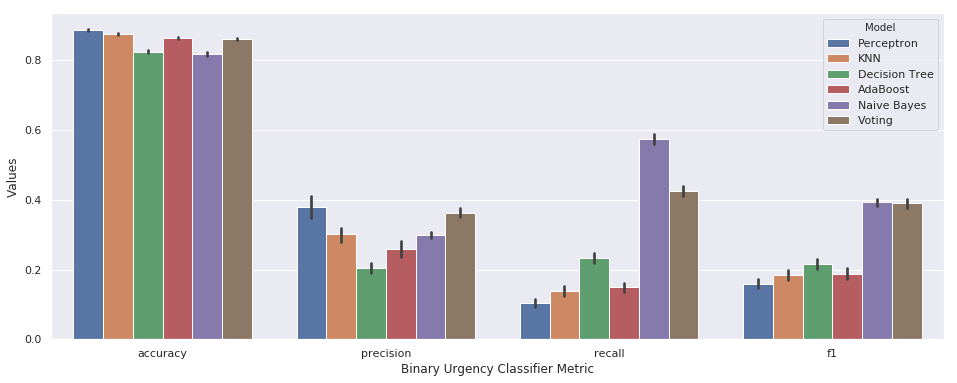

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

#now create a barplot using seaborn
plt.figure(figsize=(16, 6))
sns.barplot(x='Binary Urgency Classifier Metric', y='Values', hue='Model', data=df_stats)